# Deep Q-Learning with fixed Q-targets
---
In the previous notebook we were using the same neural network to estimate $Q(s, a, w)$ and $Q(s' a, w)$ (required for $TD_{target}$ estimates). As a result we were updating a guess with a guess. This can potentially lead to instability due to occurrence of some harmful correlations. To avoid this, we can use another, fix set of weights $w^-$ that is not changed during the learnig step to generate $TD_{target}$ according to the formula: $TD_{target} = R + \gamma \max\limits_{a'} Q(S_{t+1}, a', w^-)$ 
In practice we create a copy of the base neural network (so called `local neural network`). This copy is called a `target neural network`. Then, we are using the target neural network to estimate $TD_{target}$ and update the local neural network only.

However, we still want the target neural network to be as close to the local neural network as possible, so we need to update it somehow. There are two main approaches:
- update target neural network every $n$ steps or every $n$ episodes - this approach is used in this solution
- perform a soft-update of the target weights according to the formula: $w_{target} = \tau*w_{local} + (1 - \tau)*w_{target}$. Where $\tau$ is a parameter that determines update speed (usually very small, like 0.001).


In [1]:
# Import packages
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cuda:0


In [2]:
env = gym.make(config.ENVIRONMENT)

In [3]:
from lib.fixed_qtarget_agent import Agent

agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n, device=device)


In [6]:
def train_agent(n_episodes=config.MAX_EPISODES, 
        max_t=config.MAX_TIMESTEPS, 
        eps_start=config.EPSILON_START, 
        eps_end=config.EPSILON_END, 
        eps_decay=config.EPSILON_DECAY,
        expected_reward = config.EXPECTED_REWARD,
        update_target_every = 4
):
    """Deep Q-Learning.
    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
        upate_target_every (int): how often should the target 
            network be updated. Default: 1 (per every episode) 
    Returns:
        scores (list): list of scores from each episode
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
                
        eps = max(eps_end, eps_decay*eps) 
        
        if episode % update_target_every == 0:
            agent.target_hard_update()
        
        mean_score = np.mean(scores_window)
        print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}', end="")
        if episode % 100 == 0:
            print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
            break
    return scores

### Train the agent


Episode 100	Average Score: 17.81
Episode 200	Average Score: 13.34
Episode 300	Average Score: 31.85
Episode 400	Average Score: 121.20
Episode 478	Average Score: 231.03
Done in 478 episodes!	Average Score: 231.03


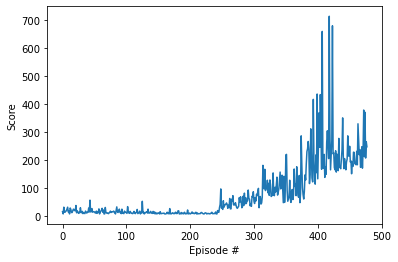

In [7]:
scores = train_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()